In [30]:
%pip install optuna==3.6.0
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [31]:
import optuna
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, \
                            f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import pickle

In [32]:
# Muat data
with open("train_test_data.pkl", "rb") as f:
    data = pickle.load(f)
    X_train = data["X_train"]
    X_test = data["X_test"]
    y_train = data["y_train"]
    y_test = data["y_test"]

# Muat pipeline preprocessing (BELUM DI-FIT)
with open("preprocessing_pipeline.pkl", "rb") as f:
    preprocess = pickle.load(f) 

# Opsional: muat nama fitur
with open("feature_names.pkl", "rb") as f:
    feature_names = pickle.load(f)

## Bangun XGBoost

In [33]:
# ============================================================
# Membangun model XGBoost
# ============================================================

seed = 42
# hyperparameter untuk keseimbangan kelas (proporsi distribusi)
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Cari best XGBoost (Base Model) dengan Optuna
def objective_xgb(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 120), #jumlah pohon
        'max_depth': trial.suggest_int('max_depth', 2, 3), #kedalaman pohon
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1), #laju pembelajaran
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 15), #berapa child yang di split
        'gamma': trial.suggest_float('gamma', 0.5, 5.0), #regularisasi untuk bobot pohon
        'subsample': trial.suggest_float('subsample', 0.6, 0.85), #proporsi data latih yang digunakan setiap pohon
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.85), #proporsi fitur yang digunakan pohon
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 5.0), #penalti L1 untuk daun
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0), #penalti L2 untuk daun
        'scale_pos_weight': scale_pos_weight,
        'eval_metric': 'logloss',
        'random_state': seed,
        'n_jobs': -1 #Mempercepat waktu eksekusi
    }

    xgb_model = XGBClassifier(**params)
    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("clf", xgb_model),
    ])
    return cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()

study_xgb = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))
study_xgb.optimize(objective_xgb, n_trials=100)

print("Best XGB Params:", study_xgb.best_params)

# Simpan best params ke file
with open("best_params.pkl", "wb") as f:
    pickle.dump({
        "xgb": study_xgb.best_params,
        # "lasso": {}  # nanti akan diisi di file 07
    }, f)
    
# Create the full pipeline for XGBoost, including preprocessing
best_xgb = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", XGBClassifier(
        **study_xgb.best_params,
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        random_state=seed,
        n_jobs=-1
    ))
])

# Fit this full pipeline. This 'best_xgb' will now be used consistently in StackingClassifier
best_xgb.fit(X_train, y_train)

[I 2026-01-19 23:19:50,931] A new study created in memory with name: no-name-e07b2d32-7e6f-4b16-9170-a83bc68fc384
[I 2026-01-19 23:19:55,424] Trial 0 finished with value: 0.8681274019041579 and parameters: {'n_estimators': 64, 'max_depth': 3, 'learning_rate': 0.08123957592679837, 'min_child_weight': 11, 'gamma': 1.2020838819909643, 'subsample': 0.6389986300840507, 'colsample_bytree': 0.6145209030420499, 'reg_alpha': 4.344263114297182, 'reg_lambda': 6.41003510568888}. Best is trial 0 with value: 0.8681274019041579.
[I 2026-01-19 23:19:58,696] Trial 1 finished with value: 0.8492659101376399 and parameters: {'n_estimators': 94, 'max_depth': 2, 'learning_rate': 0.09789368965133961, 'min_child_weight': 14, 'gamma': 1.4555259980522428, 'subsample': 0.6454562418017751, 'colsample_bytree': 0.6458511274633585, 'reg_alpha': 1.590786990501735, 'reg_lambda': 5.72280788469014}. Best is trial 0 with value: 0.8681274019041579.
[I 2026-01-19 23:20:00,750] Trial 2 finished with value: 0.863700332963374

Best XGB Params: {'n_estimators': 42, 'max_depth': 3, 'learning_rate': 0.05998885620679123, 'min_child_weight': 13, 'gamma': 4.927715490339331, 'subsample': 0.8492052227095725, 'colsample_bytree': 0.7157495271738483, 'reg_alpha': 4.525299856593533, 'reg_lambda': 1.5650633164135164}


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('te', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains

# Evaluasi Model

In [34]:
def evaluate_cv_stability(model, X, y, cv, model_name="Model"):
    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    mean_auc = scores.mean()
    std_auc = scores.std()

    print(f"{model_name}")
    print(f"ROC-AUC CV Mean : {mean_auc:.4f}")
    print(f"ROC-AUC CV Std  : {std_auc:.4f}")
    print("-" * 40)

    return mean_auc, std_auc


In [35]:
# ============================================================
# FUNGSI EVALUASI
# ============================================================
def evaluate_model_full(y_true, y_proba, name="Model"):
    roc_auc = roc_auc_score(y_true, y_proba)
    y_pred = (y_proba >= 0.5).astype(int)

    recall_fraud = recall_score(y_true, y_pred, pos_label=1)
    precision_fraud = precision_score(y_true, y_pred, pos_label=1)
    f1_fraud = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    print(f"=== {name} ===")
    print(f" ROC-AUC            : {roc_auc:.4f}")
    print(f" Accuracy           : {accuracy:.4f}")
    print(f" Precision (Fraud)  : {precision_fraud:.4f}")
    print(f" Recall (Fraud)     : {recall_fraud:.4f}")
    print(f" F1-Score (Fraud)   : {f1_fraud:.4f}")
    print(f" Specificity (Non-F): {specificity:.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 60)

In [36]:
# ============================================================
# EVALUASI: XGBoost (data test)
# ============================================================

y_proba_xgb   = best_xgb.predict_proba(X_test)[:, 1]

evaluate_model_full(y_test, y_proba_xgb,
                    "Baseline XGBoost (Tuned Bayesian)")


=== Baseline XGBoost (Tuned Bayesian) ===
 ROC-AUC            : 0.8485
 Accuracy           : 0.8300
 Precision (Fraud)  : 0.6353
 Recall (Fraud)     : 0.7297
 F1-Score (Fraud)   : 0.6792
 Specificity (Non-F): 0.8628
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       226
           1       0.64      0.73      0.68        74

    accuracy                           0.83       300
   macro avg       0.77      0.80      0.78       300
weighted avg       0.84      0.83      0.83       300

------------------------------------------------------------


In [37]:
# ============================================================
# EVALUASI: XGBoost (data train)
# ============================================================

y_proba_xgb_train   = best_xgb.predict_proba(X_train)[:, 1]

evaluate_model_full(y_train, y_proba_xgb_train,
                    "Baseline XGBoost (Tuned Bayesian)")

=== Baseline XGBoost (Tuned Bayesian) ===
 ROC-AUC            : 0.9457
 Accuracy           : 0.8755
 Precision (Fraud)  : 0.6920
 Recall (Fraud)     : 0.8960
 F1-Score (Fraud)   : 0.7809
 Specificity (Non-F): 0.8688
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       526
           1       0.69      0.90      0.78       173

    accuracy                           0.88       699
   macro avg       0.83      0.88      0.85       699
weighted avg       0.90      0.88      0.88       699

------------------------------------------------------------


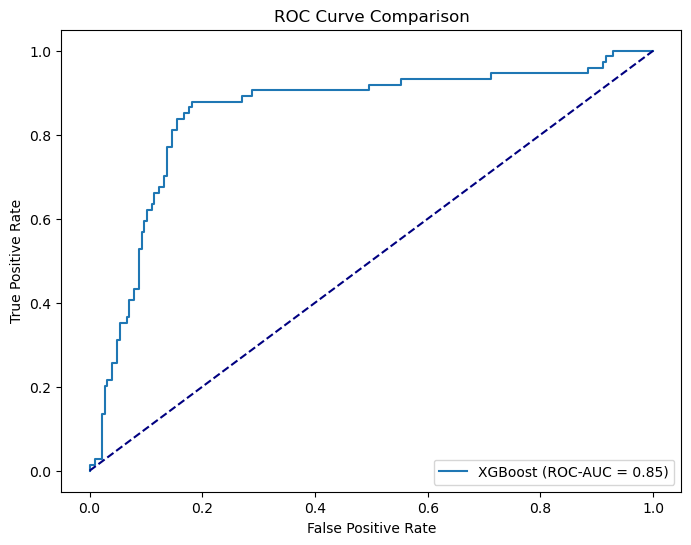

In [38]:
# Menghitung probabilitas untuk tiap model
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Menghitung ROC curve untuk tiap model
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (ROC-AUC = %0.2f)' % roc_auc_score(y_test, y_proba_xgb))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


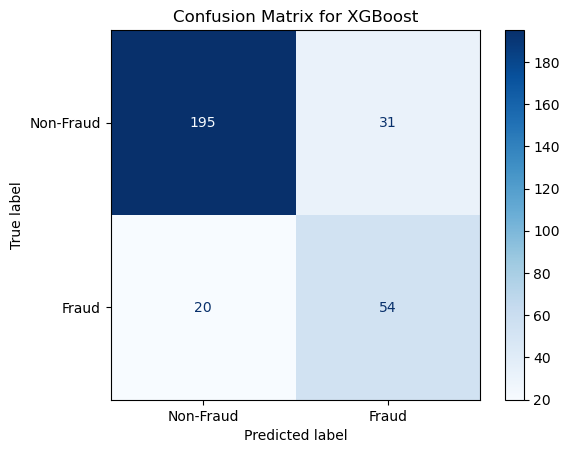

In [39]:
# Confusion Matrix untuk XGBoost
cm_xgb = confusion_matrix(y_test, (y_proba_xgb >= 0.5).astype(int))
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Non-Fraud", "Fraud"])
disp_xgb.plot(cmap="Blues")
plt.title("Confusion Matrix for XGBoost")
plt.show()

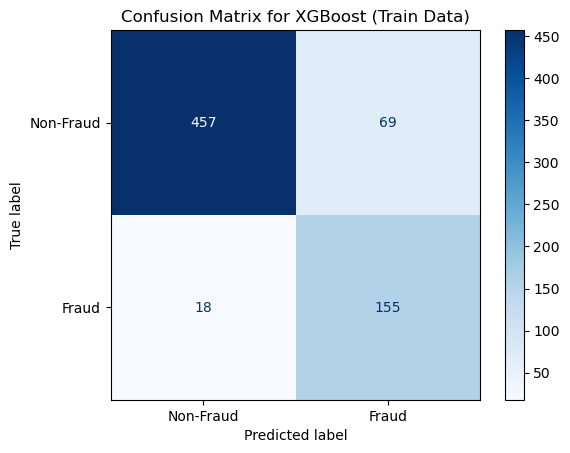

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities on training data
y_train_proba_xgb = best_xgb.predict_proba(X_train)[:, 1]

# Confusion Matrix for XGBoost on training data
cm_train_xgb = confusion_matrix(y_train, (y_train_proba_xgb >= 0.5).astype(int))
disp_train_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_train_xgb, display_labels=["Non-Fraud", "Fraud"])
disp_train_xgb.plot(cmap="Blues")
plt.title("Confusion Matrix for XGBoost (Train Data)")
plt.show()


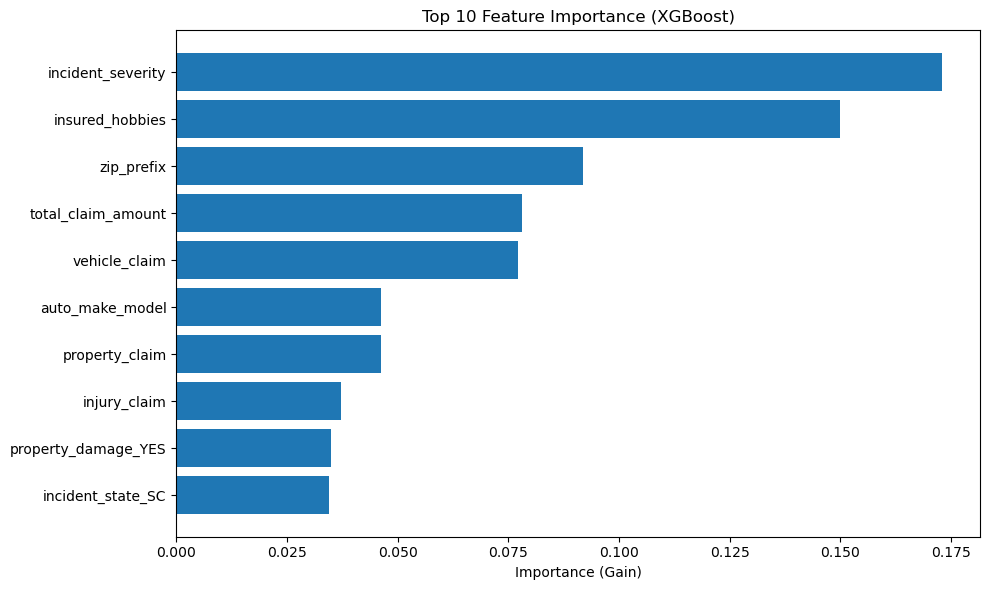

In [41]:
# Ambil importance
importances = best_xgb.named_steps['clf'].feature_importances_
assert len(feature_names) == len(importances), f"Jumlah fitur tidak cocok: {len(feature_names)} vs {len(importances)}"

# Buat DataFrame
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'][:10], feat_imp['importance'][:10])
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importance (XGBoost)')
plt.xlabel('Importance (Gain)')
plt.tight_layout()
plt.show()

# info tambahan

In [42]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# XGBoost
xgb_mean, xgb_std = evaluate_cv_stability(
    best_xgb,
    X_train,
    y_train,
    cv,
    model_name="XGBoost"
)

XGBoost
ROC-AUC CV Mean : 0.8880
ROC-AUC CV Std  : 0.0201
----------------------------------------
